# Experiment on Sufficient Query Specification

In [1]:
import pandas as pd
from common.model import Prompt
from common.classification import create_input_instances, create_batch_file, start_batch_job, retrieve_batch_results

## Load Data and Prompts

In [2]:
data_specification_prompt = Prompt.load("./prompts/sufficient_specification/14_sufficient_data_specification.json")
procedural_specification_prompt = Prompt.load("./prompts/sufficient_specification/12_sufficient_procedural_specification.json")

sampled_queries = pd.read_parquet("./data/inputs/sampled_queries.parquet")

## Create Batch Files

In [3]:
data_classification_ids = [f"data_specification-dev-set-{index}" for index, _ in sampled_queries.iterrows()]
procedural_classification_ids = [f"procedural_specification-dev-set-{index}" for index, _ in sampled_queries.iterrows()]

data_specification_batch_size = int(len(data_classification_ids) / 5) + 1
procedural_specification_batch_size = int(len(procedural_classification_ids) / 3) + 1


ind = 0
batch_index = 0
data_specification_batch_files = []
while ind < len(data_classification_ids):
    batch_ids = data_classification_ids[ind:ind+data_specification_batch_size]
    batch_queries = sampled_queries["query"].loc[ind:ind+data_specification_batch_size]

    input_instances = create_input_instances(batch_queries, batch_ids)

    batch_file_path = f"./batch_jobs/sufficient_specification/sufficient_data_specification_{batch_index}.json"

    create_batch_file(data_specification_prompt, input_instances, batch_file_path)
    data_specification_batch_files.append(batch_file_path)

    ind += data_specification_batch_size
    batch_index += 1

ind = 0
batch_index = 0
procedural_specification_batch_files = []
while ind < len(procedural_classification_ids):
    batch_ids = procedural_classification_ids[ind:ind+procedural_specification_batch_size]
    batch_queries = sampled_queries["query"].loc[ind:ind+procedural_specification_batch_size]

    input_instances = create_input_instances(batch_queries, batch_ids)

    batch_file_path = f"./batch_jobs/sufficient_specification/sufficient_procedural_specification_{batch_index}.json"

    create_batch_file(procedural_specification_prompt, input_instances, batch_file_path)
    procedural_specification_batch_files.append(batch_file_path)

    ind += procedural_specification_batch_size
    batch_index += 1

## Define Output Structures

In [4]:
from pydantic import BaseModel, Field
from typing import Literal

class TaskSpecification(BaseModel):
    analysis: str = Field(
        ..., description="A brief analysis of the task specification."
    )
    classification: Literal["Specified", "Underspecified"] = Field(
        ..., description="Classification of the query's overall analytical action."
    )

class ScopeSpecification(BaseModel):
    analysis: str = Field(
        ..., description="A brief analysis of the scope specification."
    )
    classification: Literal["Specified", "Underspecified"] = Field(
        ..., description="Classification of the query's analytical parameters (e.g., calculations, ranking metrics)."
    )


class ProceduralSpecification(BaseModel):
    task_specification: TaskSpecification
    scope_specification: ScopeSpecification

# Part B: Defines the "what data" - the data the procedure runs on

class EntitySpecification(BaseModel):
    analysis: str = Field(
        ..., description="A brief analysis of the entity specification."
    )
    classification: Literal["Specified", "Underspecified"] = Field(
        ..., description="Classification of the query's core subjects (nouns)."
    )

class TemporalSpecification(BaseModel):
    analysis: str = Field(
        ..., description="A brief analysis of the temporal specification."
    )
    classification: Literal[
        "Specified",
        "Underspecified (Assuming Recency)",
        "Underspecified (Ambiguous)",
        "Not Applicable",
    ] = Field(..., description="Classification of the query's temporal specification.")

class DomainSpecification(BaseModel):
    analysis: str = Field(
        ..., description="A brief analysis of the domain specification."
    )
    classification: Literal[
        "Specified",
        "Underspecified (Assuming Universal Domain)",
        "Underspecified (Ambiguous)",
    ] = Field(..., description="Classification of the query's domain/contextual boundary (geographical, organizational, etc.).")

class DataSpecification(BaseModel):
    entity_specification: EntitySpecification
    temporal_specification: TemporalSpecification
    domain_specification: DomainSpecification

# Top-level model

class QuerySpecification(BaseModel):
    procedural_specification: ProceduralSpecification
    data_specification: DataSpecification

## Run Batch Jobs on Data Specification

In [7]:
from typing import List, TypeVar, Tuple
from pydantic import BaseModel
import time
from tqdm.notebook import tqdm
from openai import OpenAI


T = TypeVar("T", bound=BaseModel)


def run_batch_jobs(batch_files: List[str], classification_target: type[T]) -> List[Tuple[List[str], List[T]]]:
    batches_results = []
    openai_client = OpenAI()
    for batch_file_path in tqdm(batch_files, desc="Processing batch files"):
        batch = start_batch_job(batch_file_path)
        progress_bar = tqdm(total=batch.request_counts.total, desc=f"Batch {batch.id} Progress", leave=False)
        while True:
            progress_bar.update(batch.request_counts.completed - progress_bar.n)
            try:
                batch_results = retrieve_batch_results(batch, classification_target)
                batches_results.append(batch_results)
                progress_bar.close()
                break
            except RuntimeError:
                time.sleep(60)
                batch = openai_client.batches.retrieve(batch.id)
                progress_bar.total = batch.request_counts.total
                progress_bar.refresh()

    return batches_results

In [8]:
data_batches_results = run_batch_jobs(data_specification_batch_files, DataSpecification)

Processing batch files:   0%|          | 0/5 [00:00<?, ?it/s]

Batch batch_68e7b73ee3648190960cb990af021a8a Progress: 0it [00:00, ?it/s]

Batch batch_68e7bcc2cda881909da60524ca1dd280 Progress: 0it [00:00, ?it/s]

Batch batch_68e7c372305881909375503fcb484a71 Progress: 0it [00:00, ?it/s]

Batch batch_68e7c80956dc81908d88842d20387cbe Progress: 0it [00:00, ?it/s]

Batch batch_68e7ce3871c48190b71d199420087e8f Progress: 0it [00:00, ?it/s]

In [9]:
procedural_batches_results = run_batch_jobs(procedural_specification_batch_files, ProceduralSpecification)

Processing batch files:   0%|          | 0/3 [00:00<?, ?it/s]

Batch batch_68e83f6e7ffc8190b3e0279088fab5d7 Progress: 0it [00:00, ?it/s]

Batch batch_68e8424bb77c8190b56f8f09f87e56ae Progress: 0it [00:00, ?it/s]

Batch batch_68e84819c2988190b4125c86032d479c Progress: 0it [00:00, ?it/s]

## Post-process Results

In [15]:
# Extract IDs and classifications from batch results
data_batches_ids = [item for batch in data_batches_results for item in batch[0]]
data_batches_res = [item for batch in data_batches_results for item in batch[1]]

In [17]:
# Extract IDs and classifications from batch results
procedural_batches_ids = [item for batch in procedural_batches_results for item in batch[0]]
procedural_batches_res = [item for batch in procedural_batches_results for item in batch[1]]

In [18]:
# Populate DataFrames with classifications
data_specification = pd.DataFrame({"id": data_batches_ids, "data_specification": data_batches_res})
procedural_specification = pd.DataFrame({"id": procedural_batches_ids, "procedural_specification": procedural_batches_res})

In [23]:
# Extract classifications and analyses into separate columns
data_specification["entity_specification"] = data_specification["data_specification"].apply(lambda x: x.entity_specification.classification)
data_specification["entity_specification_analysis"] = data_specification["data_specification"].apply(lambda x: x.entity_specification.analysis)
data_specification["temporal_specification"] = data_specification["data_specification"].apply(lambda x: x.temporal_specification.classification)
data_specification["temporal_specification_analysis"] = data_specification["data_specification"].apply(lambda x: x.temporal_specification.analysis)
data_specification["domain_specification"] = data_specification["data_specification"].apply(lambda x: x.domain_specification.classification)
data_specification["domain_specification_analysis"] = data_specification["data_specification"].apply(lambda x: x.domain_specification.analysis)

In [27]:
# Adjust IDs to match sampled_queries
data_specification["in_batch_id"] = data_specification["id"]
data_specification["id"] = data_specification["in_batch_id"].apply(lambda x: int(x.split("-")[-1]))

In [29]:
# Extract classifications and analyses into separate columns
procedural_specification["task_specification"] = procedural_specification["procedural_specification"].apply(lambda x: x.task_specification.classification)
procedural_specification["task_specification_analysis"] = procedural_specification["procedural_specification"].apply(lambda x: x.task_specification.analysis)
procedural_specification["scope_specification"] = procedural_specification["procedural_specification"].apply(lambda x: x.scope_specification.classification)
procedural_specification["scope_specification_analysis"] = procedural_specification["procedural_specification"].apply(lambda x: x.scope_specification.analysis)

In [30]:
# Adjust IDs to match sampled_queries
procedural_specification["in_batch_id"] = procedural_specification["id"]
procedural_specification["id"] = procedural_specification["in_batch_id"].apply(lambda x: int(x.split("-")[-1]))

In [32]:
# Merge Data and Procedural Specifications
merged_classifications = data_specification.merge(procedural_specification, on="id", how="left")

In [35]:
# Combine with sampled queries
query_specification = sampled_queries.merge(merged_classifications, left_index=True, right_on="id", how="left")

In [37]:
# Drop unnecessary columns
query_specification = query_specification.drop(columns=["in_batch_id_x", "in_batch_id_y", "data_specification", "procedural_specification"])

In [40]:
query_specification["sufficient_entity_specification"] = query_specification["entity_specification"].apply(lambda x: x == "Specified")
query_specification["sufficient_temporal_specification"] = query_specification["temporal_specification"].apply(lambda x: x in ["Specified", "Not Applicable", "Underspecified (Assuming Recency)"])
query_specification["sufficient_domain_specification"] = query_specification["domain_specification"].apply(lambda x: x in ["Specified", "Underspecified (Assuming Universal Domain)"])
query_specification["sufficient_task_specification"] = query_specification["task_specification"].apply(lambda x: x == "Specified")
query_specification["sufficient_scope_specification"] = query_specification["scope_specification"].apply(lambda x: x == "Specified")

In [42]:
# Save final results
query_specification.to_parquet("./data/outputs/sufficient_specification/sufficient_query_specification_classification.parquet", index=False)

In [44]:
dataset_stat_mapping = []

for dataset in query_specification["dataset"].unique():
    dataset_subset = query_specification[query_specification["dataset"] == dataset]
    dataset_stat_mapping.append({
        "Dataset": dataset,
        "Task Specification": dataset_subset["sufficient_task_specification"].mean(),
        "Scope Specification": dataset_subset["sufficient_scope_specification"].mean(),
        "Entity Specification": dataset_subset["sufficient_entity_specification"].mean(),
        "Temporal Specification": dataset_subset["sufficient_temporal_specification"].mean(),
        "Domain Specification": dataset_subset["sufficient_domain_specification"].mean(),
    })

In [45]:
sufficient_specification_stats = pd.DataFrame(dataset_stat_mapping)
sufficient_specification_stats

,Dataset,Task Specification,Scope Specification,Entity Specification,Temporal Specification,Domain Specification
0,BIRD,1.000000,0.774000,0.296000,0.658000,0.298000
1,CRT-QA,0.976000,0.532000,0.552000,0.628000,0.512000
2,DA-Code,0.820000,0.378000,0.190000,0.562000,0.180000
3,DA-Eval,0.992218,0.610895,0.105058,0.653696,0.097276
4,FeTaQA,0.900000,0.820000,0.692000,0.864000,0.804000
5,HiTab,0.972000,0.684000,0.488000,0.578000,0.392000
6,KramaBench,0.990741,0.722222,0.407407,0.731481,0.453704
7,MMQA,1.000000,0.878000,0.248000,0.646000,0.230000
8,OTT-QA,0.994000,0.890000,0.558000,0.872000,0.910000
9,OpenWikiTables,0.918000,0.762000,0.672000,0.844000,0.846000


In [46]:
from matplotlib import pyplot as plt

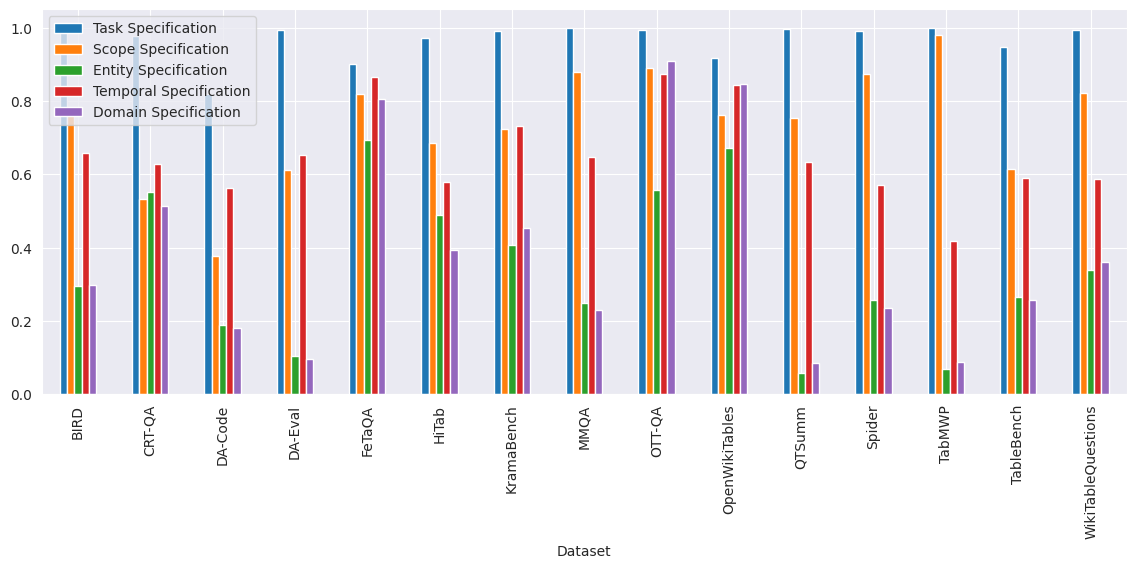

In [47]:
fig, ax = plt.subplots(figsize=(14,5))

sufficient_specification_stats.plot(ax=ax, x="Dataset", kind="bar", stacked=False)

plt.show()